<a href="https://colab.research.google.com/github/ris0801/Generalization-DeepLearning/blob/main/AdvancedProject_Figure1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Simple MLP Architecture (same as mentioned in paper)

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 113346468.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4287078.63it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25241492.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18230171.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def misclassification_rate(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct_batch = pred.eq(target.view_as(pred)).squeeze().cpu().numpy()
            # Update the correct array
            for i in range(len(correct_batch)):
                correct[i] += correct_batch[i]
    return correct


In [ ]:
def estimated_p_correct(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct[batch_idx * loader.batch_size:batch_idx * loader.batch_size + len(data)] = pred.eq(target).cpu().numpy().astype(int)
    return correct


###Function for visulazing the weights of first layer

In [ ]:
def visualize_weights(weights, img_dim=(28, 28), n_rows=5, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i][j]

            weight = weights[i * n_cols + j].detach().cpu().numpy()
            weight = weight.reshape(img_dim)

            weight = (weight - weight.min()) / (weight.max() - weight.min())

            ax.imshow(weight, cmap='gray')
            ax.axis('off')

    plt.show()

In [ ]:
num_sample_points = 1000

###Working with the actual MNIST dataset

In [ ]:
num_initializations = 25
all_p_corrects = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    # Evaluating on 1000 random data points from the full training set.
    random_indices = random.sample(range(len(train_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(train_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects += estimated_p_correct(model, subset_loader)

all_p_corrects /= num_initializations


###Visualizing the weights of first layer for MNIST data

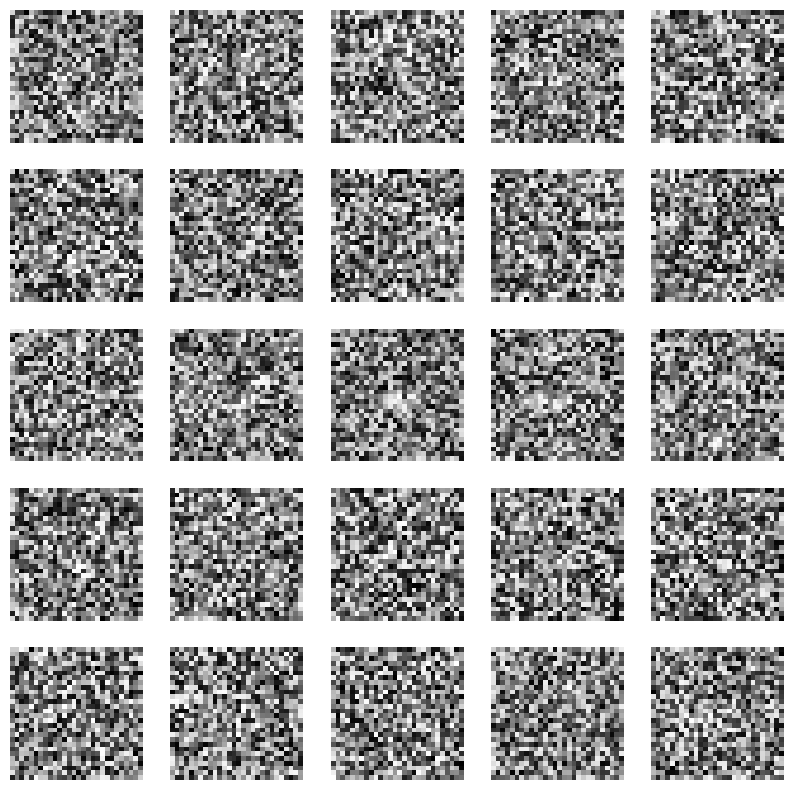

In [ ]:
# Extract the weights from the first layer
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct = np.sort(all_p_corrects)

###Working with radomized inputs

In [ ]:
# randX: Replace the input with Gaussian noise
randX_data = torch.randn_like(train_dataset.data, dtype=torch.float) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, train_dataset.targets)
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 25
all_p_corrects_randx = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randX_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randX_data)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randX_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randx += estimated_p_correct(model, subset_loader)

all_p_corrects_randx /= num_initializations

###Visualizing the weights of randomized data

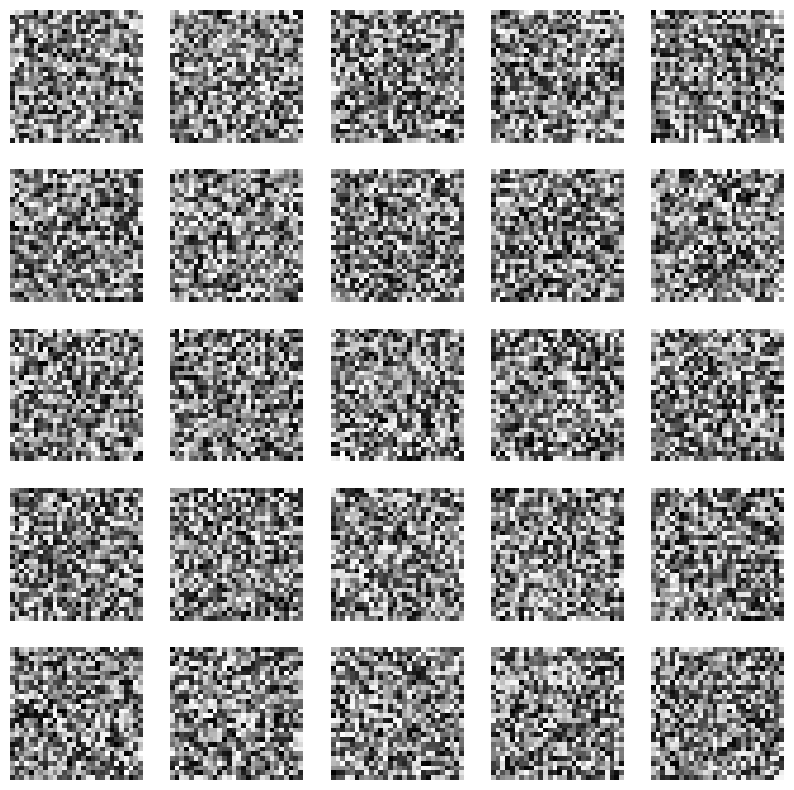

In [ ]:
# Extract the weights from the first layer
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct_randx = np.sort(all_p_corrects_randx)

### Working with random labels

In [ ]:
randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)
randY_dataset = torch.utils.data.TensorDataset(train_dataset.data.float() / 255., randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 25
all_p_corrects_randy = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randY_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randY_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randY_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randy += estimated_p_correct(model, subset_loader)

all_p_corrects_randy /= num_initializations


###Visualizing the weigths of random labels

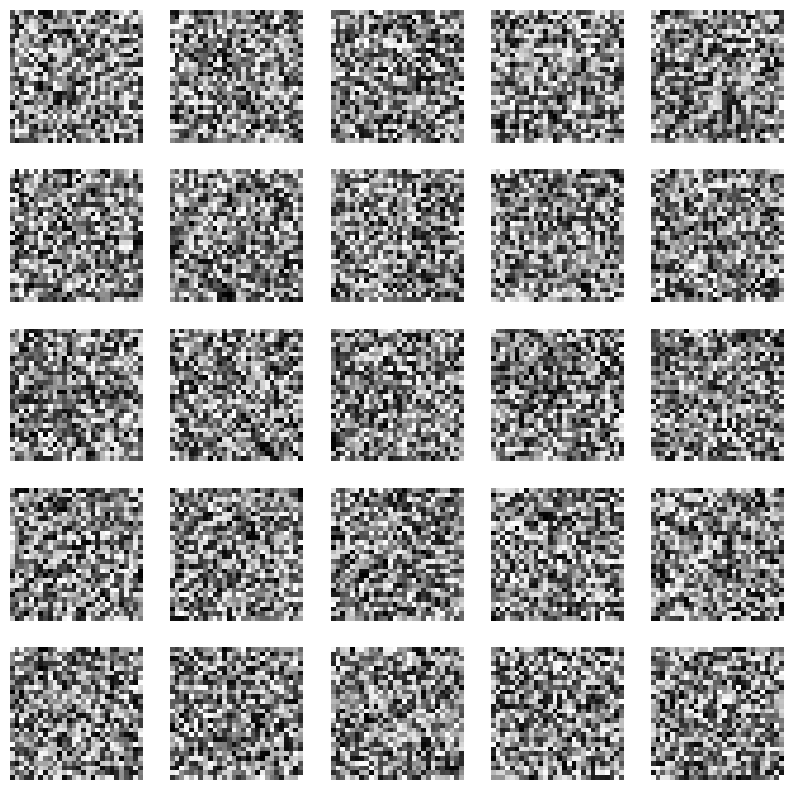

In [ ]:
# Extract the weights from the first layer
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct_randy = np.sort(all_p_corrects_randy)

###Plotting the graph to reproduce Figure#1 in paper

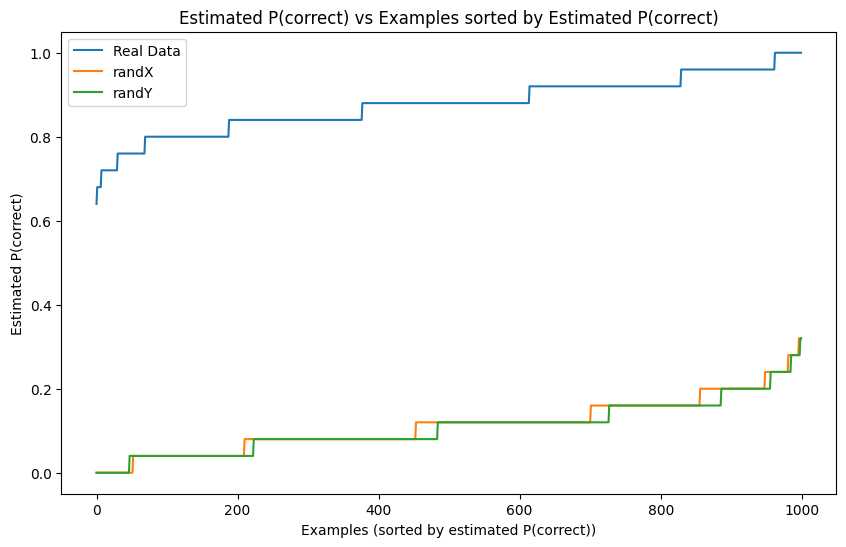

In [ ]:
plt.figure(figsize=(10,6))

# Plotting each dataset
plt.plot(sorted_p_correct, label="Real Data")
plt.plot(sorted_p_correct_randx, label="randX")
plt.plot(sorted_p_correct_randy, label="randY")

# Setting labels, title, and legend
plt.xlabel('Examples (sorted by estimated P(correct))')
plt.ylabel('Estimated P(correct)')
plt.legend()
plt.title("Estimated P(correct) vs Examples sorted by Estimated P(correct)")

# Display the plot
plt.show()


#Increased Model Size (Trying to observe behavior with increased model size)

In [ ]:
class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()

        # Input to first hidden layer
        self.fc1 = nn.Linear(28*28, 8192)

        # Added a couple more hidden layers for complexity
        self.fc2 = nn.Linear(8192, 8192)
        self.fc3 = nn.Linear(8192, 4096)
        self.fc4 = nn.Linear(4096, 4096)

        # Final layer
        self.fc5 = nn.Linear(4096, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

###With MNIST data

In [ ]:
num_initializations = 25
all_p_corrects = np.zeros(1000)

for _ in range(num_initializations):
    model = ComplexMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    # Evaluating on 1000 random data points from the full training set.
    random_indices = random.sample(range(len(train_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(train_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects += estimated_p_correct(model, subset_loader)

all_p_corrects /= num_initializations


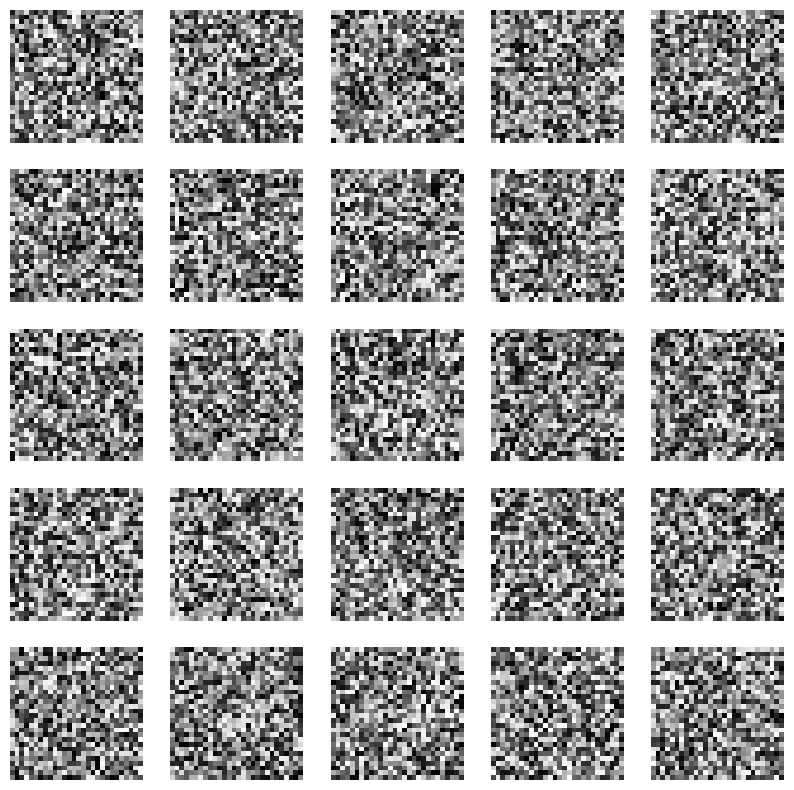

In [ ]:
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct = np.sort(all_p_corrects)

###Working with randomized input data

In [ ]:
# randX: Replace the input with Gaussian noise
randX_data = torch.randn_like(train_dataset.data, dtype=torch.float) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, train_dataset.targets)
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 25
all_p_corrects_randx = np.zeros(1000)

for _ in range(num_initializations):
    model = ComplexMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randX_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randX_data)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randX_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randx += estimated_p_correct(model, subset_loader)

all_p_corrects_randx /= num_initializations

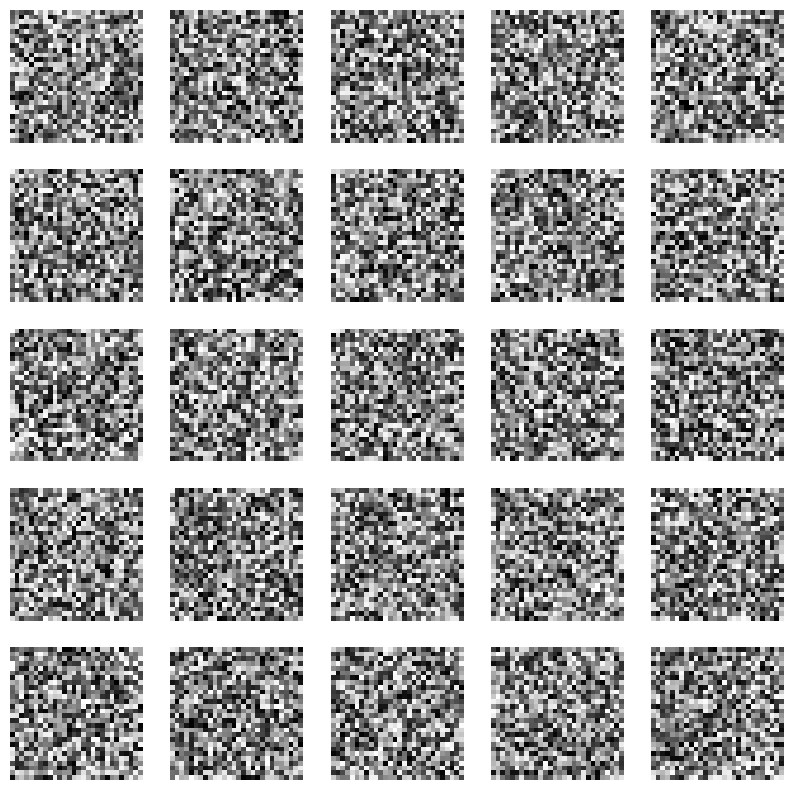

In [ ]:
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct_randx = np.sort(all_p_corrects_randx)

###Working with randomized labels

In [ ]:
randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)
randY_dataset = torch.utils.data.TensorDataset(train_dataset.data.float() / 255., randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 25
all_p_corrects_randy = np.zeros(1000)

for _ in range(num_initializations):
    model = ComplexMLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randY_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randY_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randY_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randy += estimated_p_correct(model, subset_loader)

all_p_corrects_randy /= num_initializations


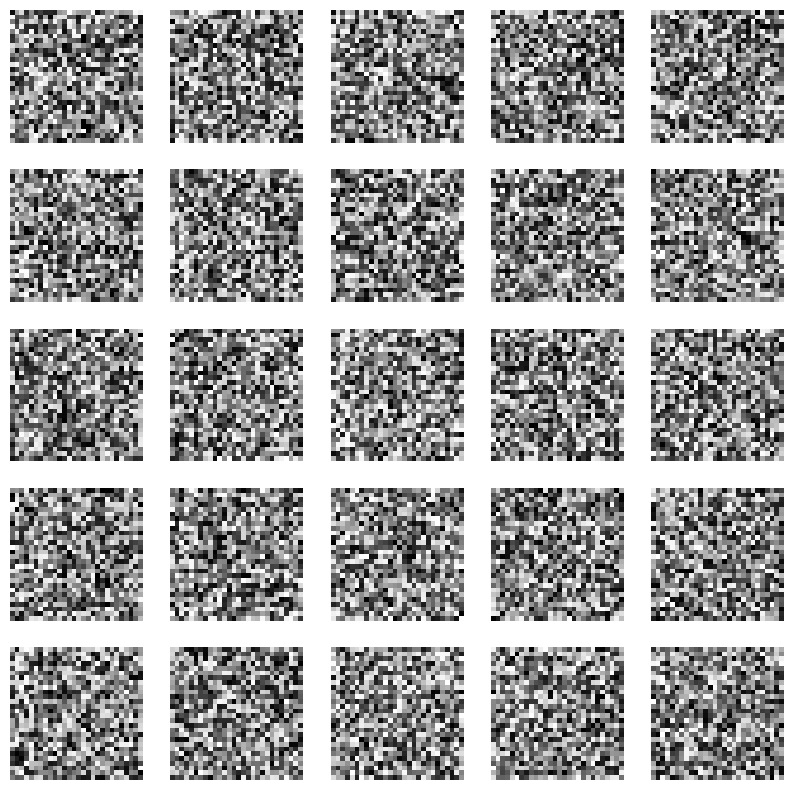

In [ ]:
weights = model.fc1.weight
visualize_weights(weights)

In [ ]:
sorted_p_correct_randx = np.sort(all_p_corrects_randy)

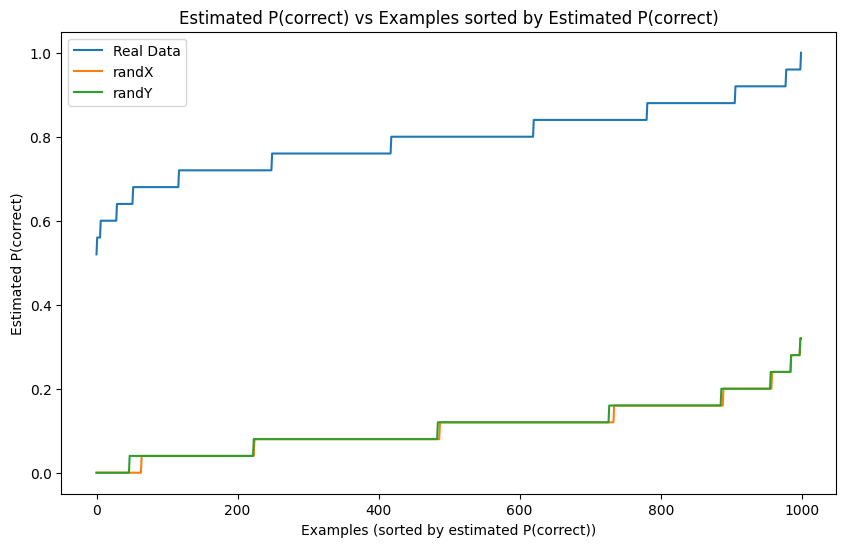

In [ ]:
plt.figure(figsize=(10,6))

# Plotting each dataset
plt.plot(sorted_p_correct, label="Real Data")
plt.plot(sorted_p_correct_randx, label="randX")
plt.plot(sorted_p_correct_randy, label="randY")

# Setting labels, title, and legend
plt.xlabel('Examples (sorted by estimated P(correct))')
plt.ylabel('Estimated P(correct)')
plt.legend()
plt.title("Estimated P(correct) vs Examples sorted by Estimated P(correct)")

# Display the plot
plt.show()

##Loss Landscape visualization

In [ ]:
def get_random_direction(model):
    direction = {}
    for name, param in model.named_parameters():
        direction[name] = torch.randn_like(param)
    return direction

def move_in_direction(model, base_state, direction, alpha):
    new_state = {}
    for name, param in model.named_parameters():
        new_state[name] = base_state[name] + alpha * direction[name]
    return new_state

In [ ]:
def loss_in_direction(model, direction, base_state, train_loader, alphas):
    losses = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for alpha in alphas:
            # Move model parameters in the direction
            state = move_in_direction(model, base_state, direction, alpha)
            for name, param in model.named_parameters():
                param.data.copy_(state[name])

            # Compute loss
            total_loss = 0.0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_loss += loss.item()
            losses.append(total_loss / len(train_loader))
    return losses


In [ ]:
model_real = SimpleMLP().to(device)
optimizer = optim.SGD(model_real.parameters(), lr=0.01)
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model_real(data)
    loss = nn.CrossEntropyLoss()(output, target)
    loss.backward()
    optimizer.step()

In [ ]:
# Save the state of trained model
base_state = {name: param.clone() for name, param in model_real.named_parameters()}

In [ ]:
# Get a random direction
direction = get_random_direction(model_real)

# Compute loss in the direction
alphas = np.linspace(-1, 1, 100)  # Steps in the direction
losses = loss_in_direction(model_real, direction, base_state, train_loader, alphas)


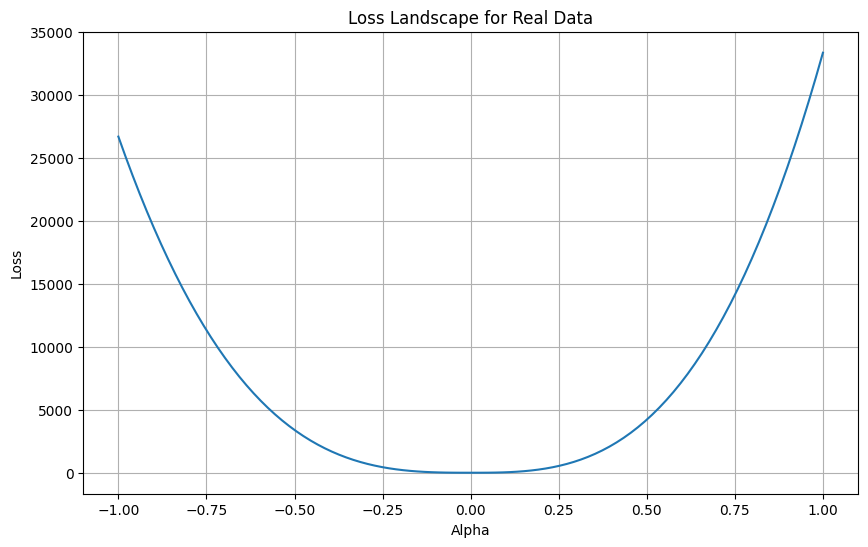

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(alphas, losses)
plt.xlabel('Alpha')
plt.ylabel('Loss')
plt.title('Loss Landscape for Real Data')
plt.grid(True)
plt.show()